In [25]:
import os
os.chdir('/engram/nklab/hossein/recurrent_models/BLT_models')
!pwd

%matplotlib inline 
import matplotlib.pyplot as plt

import datasets
import pandas as pd
import numpy as np
import csv
import torch
from matplotlib.patches import Rectangle
import torchvision
from PIL import Image
#from models.cornet import get_cornet_model
import torch.nn as nn
from collections import OrderedDict
import rsatoolbox
import torch.nn.functional as F
from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torchvision.transforms as transforms

mean = [0.485, 0.456, 0.406]  # Mean used for normalization
std = [0.229, 0.224, 0.225]  # Standard deviation used for normalization

def denormalize(tensor):
    """Denormalizes a tensor image."""
    # Create an inverse transform
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )

    # Convert the tensor to a PIL Image
    to_pil = transforms.ToPILImage()
    image = to_pil(inv_normalize(tensor))

    return image

from analyze_representations import sample_vggface2, calc_rdms, plot_maps, compare_rdms,\
  plot_recurrent_rdms, reduce_dim, plot_dim_reduction_one, sample_FEI_dataset, \
  plot_rdm_mds, load_model_path, load_pretrained_models, extract_features, kasper_dataset, \
  get_activations_batch, FBO_dataset #, calc_dprime

/engram/nklab/hossein/recurrent_models/BLT_models


### Load the dataset of faces and objects 

The faces in this dataset could be occluded and in different orientations. So not as clean as
frontal faces. 

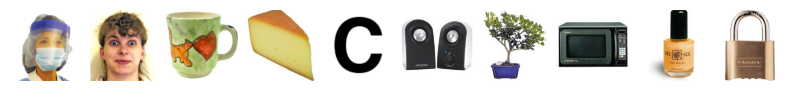

In [27]:
# load the dataset
imgs, labels, neuro_data = kasper_dataset()
imgs_gray = torchvision.transforms.Grayscale()(imgs)
imgs_gray = torch.tile(imgs_gray, (1, 3, 1, 1))

imgs = imgs[labels != 1]
imgs_gray = imgs_gray[labels != 1]
labels = labels[labels != 1]

num_faces = len(labels[labels == 0])
# len(labels[labels == 0])
# image = torchvision.transforms.ToPILImage()(imgs_gray[500])
# image

# Display a few images
n = 10
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, n)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
img_inds = np.random.choice(len(imgs), n, replace=False)
img_inds = img_inds[np.argsort(labels[img_inds])]
for i in range(n):
    ax = fig.add_subplot(gs[i])
    ax.imshow(denormalize(imgs[img_inds[i]]))
    ax.axis('off')


Some helper functions to extract featurs from the network and to calculate d-prime

In [3]:
def range_normalize(array, axis=0):
    # Find the min and max for each row
    min_vals = array.min(axis=axis, keepdims=True)
    max_vals = array.max(axis=axis, keepdims=True)
    
    # Normalize each row
    normalized_array = (array - min_vals) / (max_vals - min_vals)
    normalized_array[np.isnan(normalized_array)] = 0
    return normalized_array

def extract_model_features(model, imgs, layer, num_steps=5):

    try:
        model = model.module
    except:
        model = model

    num_chunks = len(imgs) // 64
    chunks = torch.chunk(imgs, num_chunks, dim=0)

    outputs = []
    for chunk in chunks:
        output = get_activations_batch(model, chunk, layer=layer, sublayer='output')

        #output = np.clip(output, a_max=np.percentile(output, 99), a_min=0)

        # if filter_units is not None:
        #     output = output[:, :, filter_units, :] # only take the last time-step
        #     print(output.shape)

        # average pooling over spatial dimensions in higher layers
        if layer == 'output_4' or layer == 'output_5' or layer == 'norm_5':
            # TODO: max or mean, that is the question
            output = output.reshape(*output.shape[:3], -1).mean(-1)
        else:
            output = output.reshape(*output.shape[:2], -1)

        outputs.append(output)

    output = np.concatenate(outputs, axis=1)

    features = {}
    average_features = []
    for t in range(len(output)-num_steps,len(output)):

        #output[t] = np.clip(output[t], a_max=np.percentile(output[t], 99), a_min=0)

        model_resp= output[t].copy() # 
        # TODO: z-score or range normalize or neither? 
        # Maybe if the data is after relu, we just don't do anything
        model_resp = stats.zscore(model_resp, axis=1)
        model_resp = np.clip(model_resp, a_max=np.percentile(model_resp, 95), a_min=np.percentile(model_resp, 5))
        
        #model_resp = range_normalize(model_resp, 0)
        output[t] = model_resp  

        #print(model_resp.shape)
        features[f'step {t}'] = output[t]  #/ np.max(output[t])
        average_features.append(features[f'step {t}'])

    # should I clip activations before averaging?

    features['average'] = np.mean(average_features, axis=0)
    return features

def calc_dprime(model_resp):

    #model_resp = stats.zscore(model_resp, axis=1)
    face_num = 230
    face_resp = model_resp[:,:face_num]
    non_face_resp = model_resp[:,face_num:]
    d_prime = np.mean(face_resp, axis=1) - np.mean(non_face_resp, axis=1)
    d_prime = d_prime / np.sqrt(np.var(face_resp, axis=1)/2 + np.var(non_face_resp, axis=1)/2)

    return d_prime

Question:

- What are the appropriate preprocessing for the neural data? 

- Should we z-score the activity across images for a unit for each time-step? 

- Should we normalize across time-steps? 

### Load our recurrent model. 

 We can get that before relu  and normalize ourselves. 

Number of model parameters: 6305844
blt(
  (conv_input): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool_input): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (output_prenorm_0): Identity()
  (non_lin_0): ReLU(inplace=True)
  (norm_0): GroupNorm(32, 64, eps=1e-05, affine=True)
  (output_0): Identity()
  (conv_0_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_0_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (output_prenorm_1): Identity()
  (non_lin_1): ReLU(inplace=True)
  (norm_1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (output_1): Identity()
  (conv_1_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_2): Sequential(
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (output_prenorm_2): Identity()
  (non_lin_2): ReLU(

(array([  9.,  38.,  99., 115., 122.,  80.,  35.,  10.,   2.,   2.]),
 array([-1.957937  , -1.48337257, -1.00880814, -0.53424364, -0.05967917,
         0.41488528,  0.88944972,  1.36401415,  1.8385787 ,  2.31314301,
         2.78770757]),
 <BarContainer object of 10 artists>)

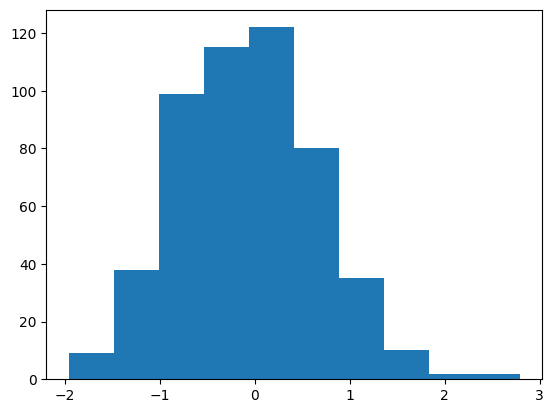

In [4]:
# This model is trained using categories from ImageNet and faces from VGGFace2
model, gap, args = load_model_path('./results/classification/imagenet_vggface2/blt_bl/run_1/', print_model=True)
layers = ['output_5']

# Extract features from the model for a given layer
# TODO: The layer could be pre_norm, norm, relu, or output. 
outputs = extract_model_features(model, imgs.to(device), 'norm_5', num_steps=5)

## test the functions 
model_resp = outputs['step 4'].transpose()
model_resp = model_resp[np.where(np.mean(model_resp, axis=1))[0],:]
d_prime = calc_dprime(model_resp)

# plt.hist(model_resp)
# plt.show()
plt.hist(d_prime)

### how correlated are d-primes from different time steps 

There are dynamics in the unit responses to different images of objects and faces across timesteps. So the d-prime calculated in one timestep could be different from another timestep. 

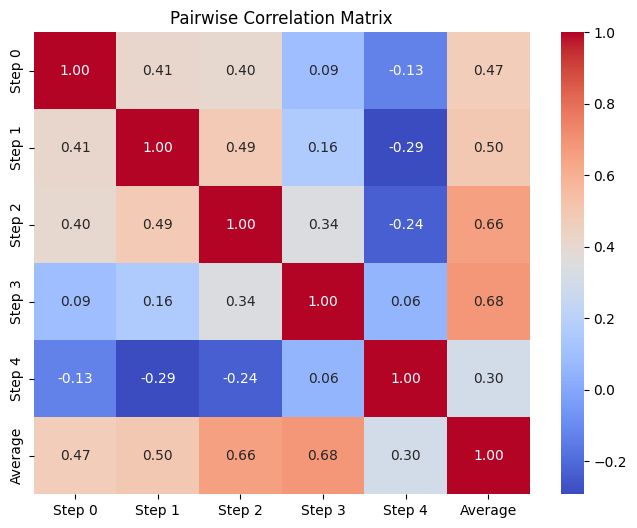

In [5]:

model_resp_steps = []
d_prime_steps = []
d_prime_dict = {}

for key, value in outputs.items():
    model_resp = outputs[key].transpose()
    #model_resp = model_resp[np.where(np.mean(model_resp, axis=1))[0],:]
    #model_resp_steps.append(model_resp)
    d_prime = np.array(calc_dprime(model_resp))
    d_prime = np.nan_to_num(d_prime, nan=0)
    d_prime_steps.append(d_prime)
    d_prime_dict[key] = d_prime


correlation_matrix = np.corrcoef(d_prime_steps)

xticklabels=[f'Step {i}' for i in range(5)] + ['Average']
yticklabels=[f'Step {i}' for i in range(5)] + ['Average']

# Step 3: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
            xticklabels=xticklabels,
            yticklabels=yticklabels)
plt.title('Pairwise Correlation Matrix')
plt.show()

Question: 

- Should the d-prime be calculated for the average neural response or for a give 
timestep (corresponding to a time-window)

- What if we do this for different time-windows and find out d-prime changes significantly. Does 
this mean that the unit is face selective in one time-window and not face-selective in another?

### plot activity of all units in response to all images 

In [6]:
# sampe the activit for the last timestep
model_resp = range_normalize(outputs['step 4'].transpose())
model_resp.shape

(512, 1162)

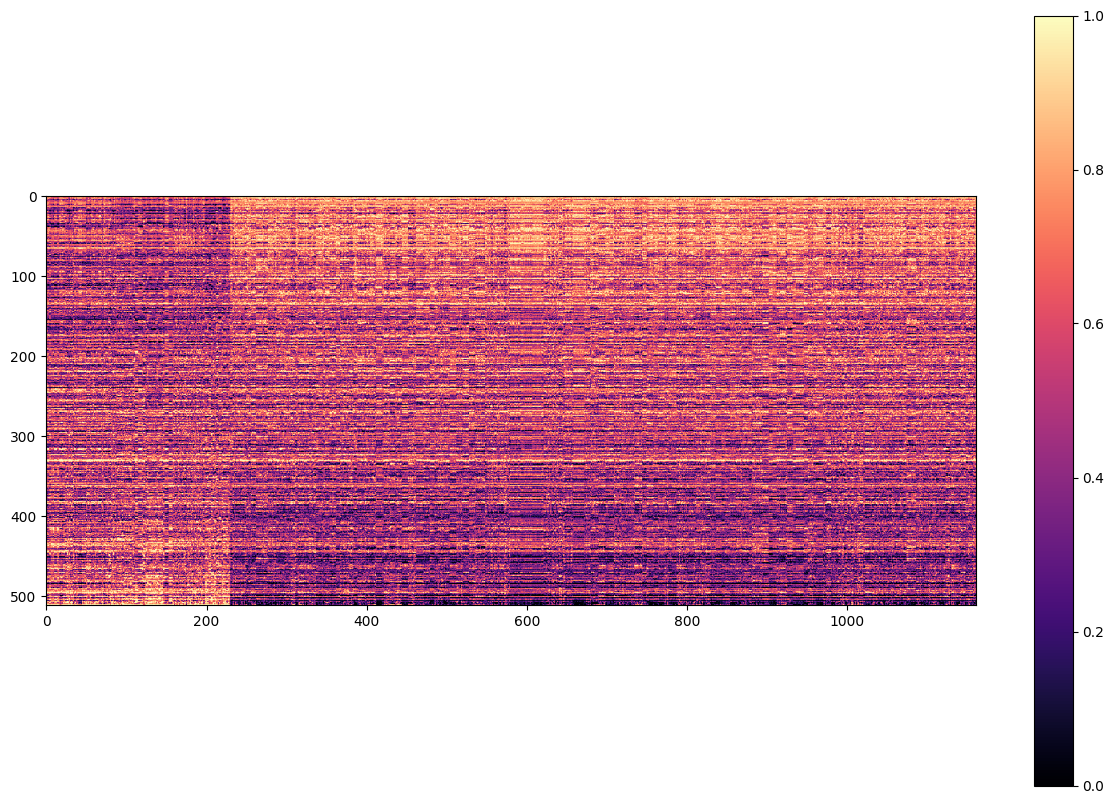

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
#plt.imshow(np.clip(model_resp, -5 , 5), cmap='magma')
d_prime = d_prime_steps[-2]
inds = np.argsort(d_prime) 

# order the units by face dprime
plt.imshow(model_resp[inds,:], cmap='magma')
plt.colorbar()
#plt.savefig('IT_response.png')

objects that have a high correlation with face dprime


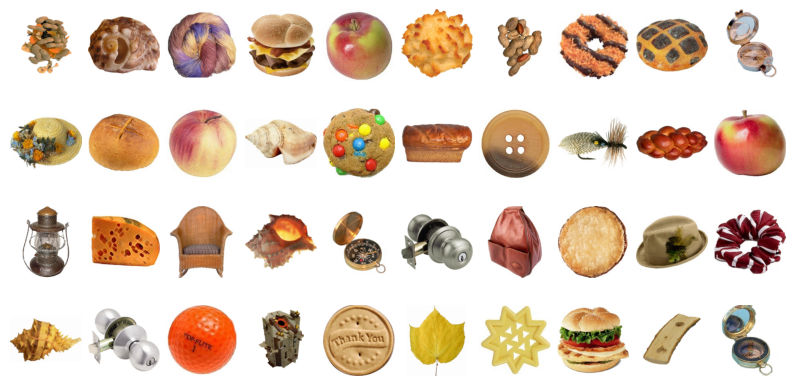

objects that have a low correlation with face dprime


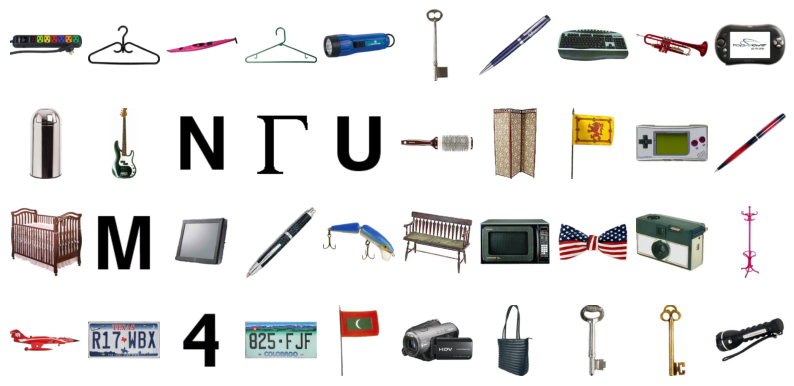

In [8]:

model_resp = range_normalize(outputs['step 4'].transpose())

# calculate the correlation between the model responses and d_prime
all_corrs = []
for im_ind in range(num_faces, imgs.shape[0]):
    
    corr_ = stats.pearsonr(model_resp[:,im_ind], d_prime)[0]
    all_corrs.append(corr_)

all_corrs = np.array(all_corrs)

all_corrs_inds = np.argsort(all_corrs)
# all_corrs = all_corrs[all_corrs_inds]

all_corrs_inds = all_corrs_inds + num_faces

top_n = 40

print('objects that have a high correlation with face dprime')

fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(4, 10)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(0,top_n):
    img = imgs[all_corrs_inds[-(i+1)]]
    ax = plt.subplot(gs[i//10,i % 10])
    ax.imshow(denormalize(img))
    ax.axis("off")

plt.show()

print('objects that have a low correlation with face dprime')

fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(4, 10)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(top_n):
    img = imgs[all_corrs_inds[i]]
    ax = plt.subplot(gs[i//10,i % 10])
    ax.imshow(denormalize(img))
    ax.axis("off")

plt.show()

In [9]:
all_corrs.shape

(932,)

In [10]:
def plot_dim_red(features, labels=None, transformer='MDS', save=None, add_text=True, add_bar=True):

    return_layers = list(features.keys())    

    fig = plt.figure(figsize=(3*len(return_layers), 4))
    # and we add one plot per reference point
    gs = fig.add_gridspec(1, len(return_layers))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    if add_text:
        fig.text(0.55, 0.95, transformer, size=14, ha="center")

    for l in range(len(return_layers)):
        layer =  return_layers[l]
        feats = features[layer]

        ax = plt.subplot(gs[0,l])
        ax.set_aspect('equal', adjustable='box')

        amin, amax = feats.min(), feats.max()
        amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8
        ax.set_xlim([amin, amax])
        ax.set_ylim([amin, amax])
        
        # for d in range(2):
        #     feats[:, d] = feats[:, d] / (np.max(feats[:, d]) - np.mean(feats[:, d]))
        # ax.set_ylim(-1.3, 1.3)
        # ax.set_xlim(-1.3, 1.3)
        if add_text:
            ax.text(0.5, 1.1, f'{layer}', size=12, ha="center", transform=ax.transAxes) 
        ax.axis("off")
        #if l == 0: 
        # these lines are to create a discrete color bar
        # if labels is None:
        #     labels = np.zeros(len(feats[:, 0]))

        # num_colors = len(np.unique(labels))
        # cmap = plt.get_cmap('viridis_r', num_colors) # 10 discrete colors
        # norm = mpl.colors.BoundaryNorm(np.arange(-0.5,num_colors), cmap.N) 
        ax_ = ax.scatter(feats[:, 1], feats[:, 0], c=labels, cmap='viridis_r', s=3)
    
    
    if add_bar:
        fig.subplots_adjust(right=0.9, top=0.9)
        cbar_ax = fig.add_axes([0.95, 0.3, 0.01, 0.45])
        fig.colorbar(ax_, cax=cbar_ax, ticks=np.linspace(0,9,10))

    # if save:
    #     fig.savefig(f'{save}.svg', format='svg', dpi=300, bbox_inches='tight')

    return fig


RDMs for responses for all the units in each time step


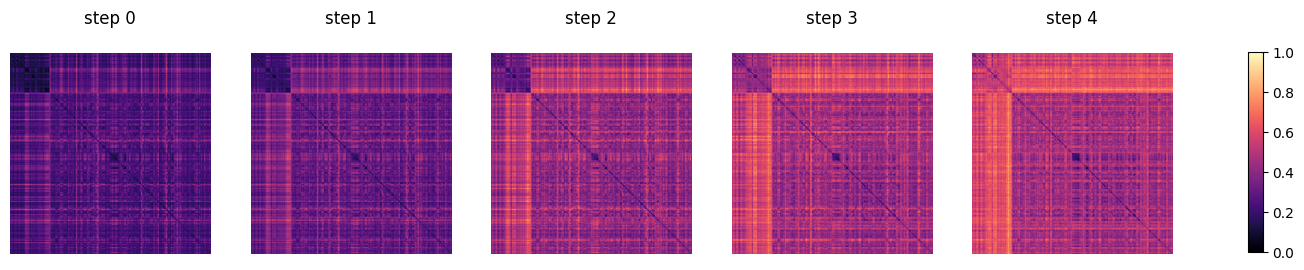

RDMs for responses for all the units with high face selectivity in each time step


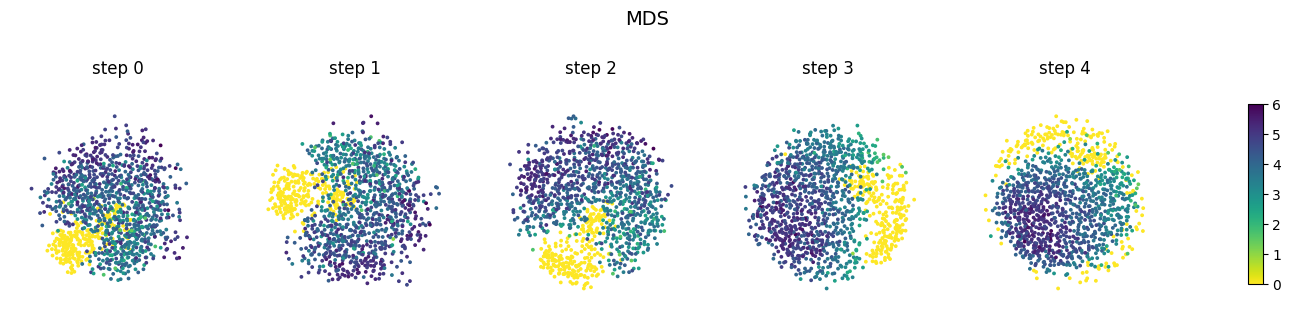

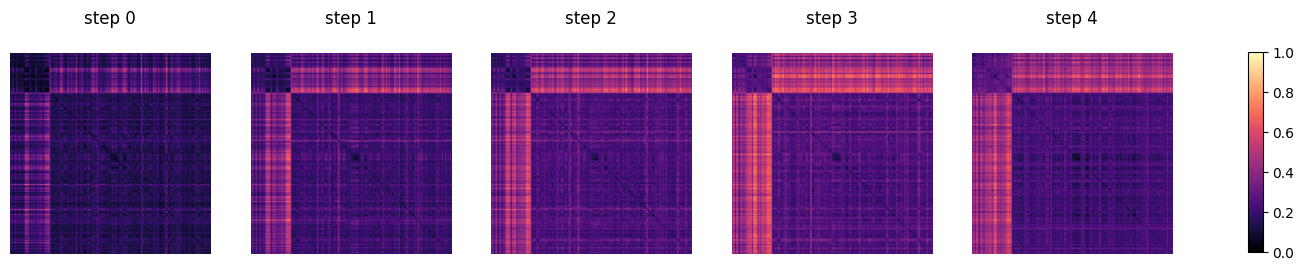

MDS plots for responses for all the units with high face selectivity in each time step


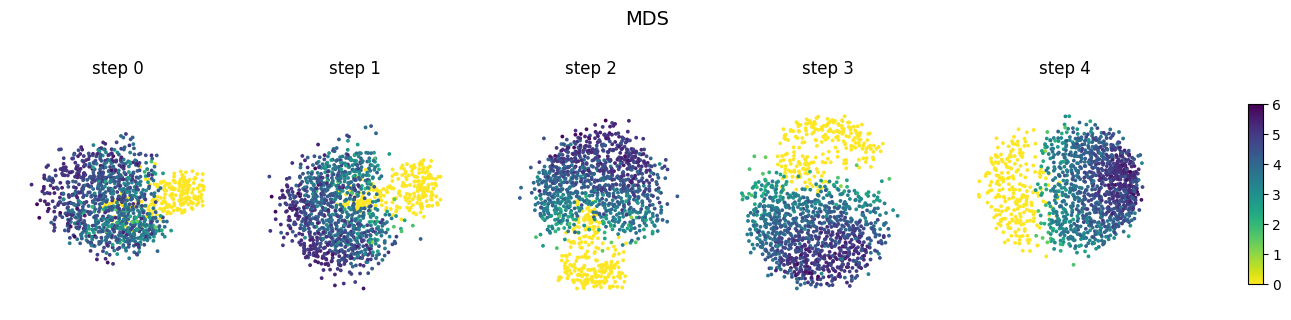

In [11]:
print('RDMs for responses for all the units in each time step')

features = {}
for key, value in outputs.items():
    if 'step' not in key:
        continue

    feats = outputs[key]

    d_prime = d_prime_dict[key]

    # inds = np.argsort(-all_corrs)  
    # inds = np.concatenate((np.arange(num_faces), all_corrs_inds))
    features[key]  = feats #[inds,:]

_, rdms_dict = calc_rdms(features)
fig = plot_maps(rdms_dict)
plt.show()

print('RDMs for responses for all the units with high face selectivity in each time step')

features_transformed = reduce_dim(features)
d_prime_corr_labels = np.concatenate((np.zeros(num_faces), 1+5*range_normalize(-all_corrs)))
fig = plot_dim_red(features_transformed, d_prime_corr_labels)

features = {}
for key, value in outputs.items():
    if 'step' not in key:
        continue

    feats = outputs[key]

    d_prime = d_prime_dict[key]
    feats = feats[:,np.where(d_prime>0.8)[0]]

    # inds = np.argsort(-all_corrs)  
    # inds = np.concatenate((np.arange(num_faces), all_corrs_inds))
    features[key]  = feats #[inds,:]

_, rdms_dict = calc_rdms(features)
fig = plot_maps(rdms_dict)
plt.show()

print('MDS plots for responses for all the units with high face selectivity in each time step')

# d_prime_corr_labels = labels.copy()
# corr_labels =  (10*(all_corrs[230:]-np.min(all_corrs[230:]))).astype(int)
# corr_labels = 1 + (np.max(corr_labels) - corr_labels)
# d_prime_corr_labels[230:] = corr_labels
features_transformed = reduce_dim(features)
d_prime_corr_labels = np.concatenate((np.zeros(num_faces), 1+5*range_normalize(-all_corrs)))
fig = plot_dim_red(features_transformed, d_prime_corr_labels)

AlexNet features

In [12]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alexnet.to(device) # send the model to the chosen device ('cpu' or 'cuda')
alexnet.eval()
print(alexnet)
train_nodes, _ = get_graph_node_names(alexnet)
print(train_nodes)
model_layer = 'classifier.1'
feature_extractor = create_feature_extractor(alexnet, return_nodes=[model_layer])

alexnet_feats = feature_extractor(imgs_gray.to(device))

fc6 = alexnet_feats[model_layer].cpu().detach().numpy()
fc6 = stats.zscore(fc6, axis=1)
fc6.shape

Using cache found in /home/ha2366/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

(1162, 4096)

Extract AlexNet fc6 features from the same experimental images 

Questions:

- Should the images that we use to create this representational bases be different than the experimental images? 

- Which one of these to pick? They all have 4096 dimensions:

    (1): Linear(in_features=9216, out_features=4096, bias=True)

    (2): ReLU(inplace=True)

    (3): Dropout(p=0.5, inplace=False)

    (4): Linear(in_features=4096, out_features=4096, bias=True)

    (5): ReLU(inplace=True)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=60)
feats_transformed = pca.fit_transform(fc6)

axis = 1  # For example, axis 0 for columns

# Calculate the mean and standard deviation along the specified axis
mean = np.mean(feats_transformed, axis=axis, keepdims=True)
std_dev = np.std(feats_transformed, axis=axis, keepdims=True)

# Standardize the data
standardized_data = (feats_transformed - mean) / std_dev

feats_transformed = {}
feats_transformed['fc6'] = standardized_data

Use PCA to reduce the dimension to 60

And then standardize the data along each PC? 

In [14]:
import matplotlib as mpl

def plot_pcs(features, labels=None, transformer='MDS', save=None, add_text=True, add_bar=True, color_map='viridis_r'):

    return_layers = list(features.keys())    

    fig = plt.figure(figsize=(3*len(return_layers), 4))
    # and we add one plot per reference point
    gs = fig.add_gridspec(1, len(return_layers))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    if add_text:
        fig.text(0.55, 0.95, transformer, size=14, ha="center")

    for l in range(len(return_layers)):
        layer =  return_layers[l]
        feats = features[layer]

        lablels_l = labels[layer]

        ax = plt.subplot(gs[0,l])
        ax.set_aspect('equal', adjustable='box')

        amin, amax = feats.min(), feats.max()
        amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8
        ax.set_xlim([amin, amax])
        ax.set_ylim([amin, amax])
        
        # for d in range(2):
        #     feats[:, d] = feats[:, d] / (np.max(feats[:, d]) - np.mean(feats[:, d]))
        # ax.set_ylim(-1.3, 1.3)
        # ax.set_xlim(-1.3, 1.3)
        if add_text:
            ax.text(0.5, 1.1, f'{layer}', size=12, ha="center", transform=ax.transAxes) 
        #ax.axis("off")
        #if l == 0: 
        # these lines are to create a discrete color bar
        # if labels is None:
        #     lablels_l = np.zeros(len(feats[:, 0]))

        # num_colors = len(np.unique(lablels_l))
        # cmap = plt.get_cmap(color_map, num_colors) # 10 discrete colors
        # norm = mpl.colors.BoundaryNorm(np.arange(-0.5,num_colors), cmap.N)  # norm=norm,
        ax_ = ax.scatter(feats[:, 0], -feats[:, 1], c=lablels_l, cmap=color_map, s=3)

        ax.set_xlim([-8, 8])
        ax.set_ylim([-8, 8])
    
    
    if add_bar:
        fig.subplots_adjust(right=0.9, top=0.9)
        cbar_ax = fig.add_axes([0.95, 0.3, 0.01, 0.45])
        fig.colorbar(ax_, cax=cbar_ax, ticks=np.linspace(0,9,10))

    # if save:
    #     fig.savefig(f'{save}.svg', format='svg', dpi=300, bbox_inches='tight')

    return fig

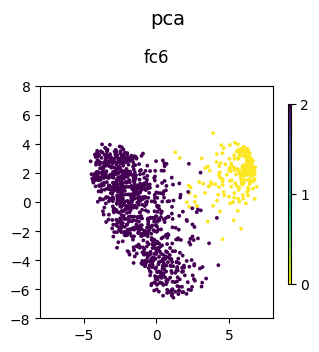

In [15]:
labels_dict = {}
labels_dict['fc6'] = labels
fig = plot_pcs(feats_transformed, labels_dict, transformer='pca')

In [16]:
model_resp_steps = []
for key, value in outputs.items():
    if 'step' in key:
        model_resp_steps.append(outputs[key].transpose())

model_resp_steps = np.array(model_resp_steps)

threshold = 0.2
#  TODO which step should be used for dprime to select face cells
d_prime = d_prime_steps[0]
face_cell_inds = np.where(d_prime > threshold)[0]
face_cell_resp_steps = model_resp_steps[:,face_cell_inds, :] 

# max_vals = face_cell_resp_steps.max(axis=0, keepdims=True)
# Normalize each row
# face_cell_resp_steps = face_cell_resp_steps / max_vals
# face_cell_resp_steps = stats.zscore(face_cell_resp_steps, axis=1)
# face_cell_resp_steps = stats.zscore(face_cell_resp_steps, axis=0)

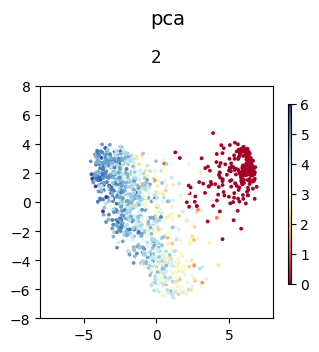

In [17]:
from sklearn.preprocessing import KBinsDiscretizer

labels_dict = {}
feat_objects = {}

for step in[2]: # range(len(face_cell_resp_steps)-1):

    feat_objects[str(step)] = feats_transformed['fc6']

    unit_response = np.concatenate((np.zeros(num_faces), 1+5*range_normalize(-all_corrs)))

    labels_dict[str(step)] = unit_response


fig = plot_pcs(feat_objects, labels_dict, transformer='pca', color_map='RdYlBu')

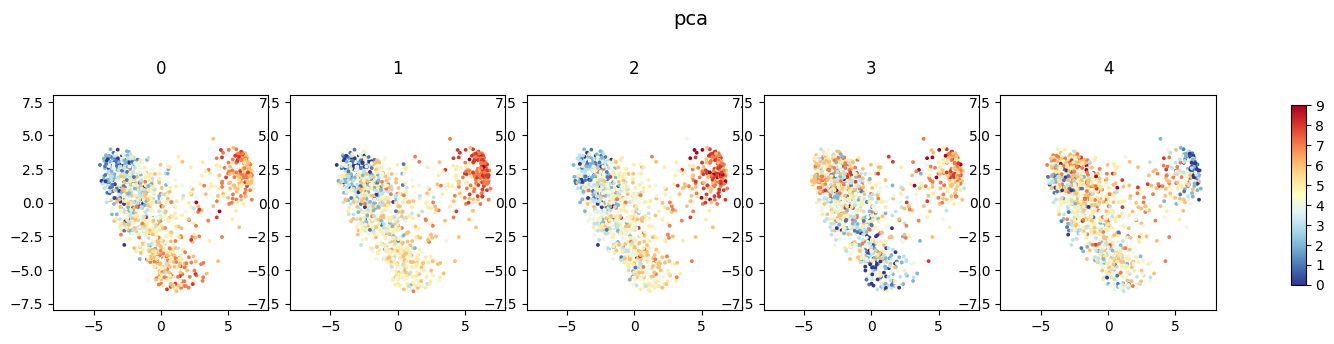

In [23]:
from sklearn.preprocessing import KBinsDiscretizer

unit = 20
#unit_response = face_cell_resp_steps.mean(axis=0)[unit].reshape(-1, 1)
labels_dict = {}
feat_objects = {}

start = -2
end = 2 # 2.2
# Create bins with a step size of 0.2
step_size = 0.5 # 0.2
bins = np.arange(start, end + step_size, step_size)

for step in range(len(face_cell_resp_steps)):

    feat_objects[str(step)] = feats_transformed['fc6']

    unit_response = face_cell_resp_steps[step][unit].reshape(-1, 1)

    # so we can use the same scale for all the time-steps
    unit_response = stats.zscore(unit_response, axis=0)

    # Discretize the array using the defined bins
    discretized = np.digitize(unit_response, bins)

    labels_dict[str(step)] = discretized

fig = plot_pcs(feat_objects, labels_dict, transformer='pca', color_map='RdYlBu_r')

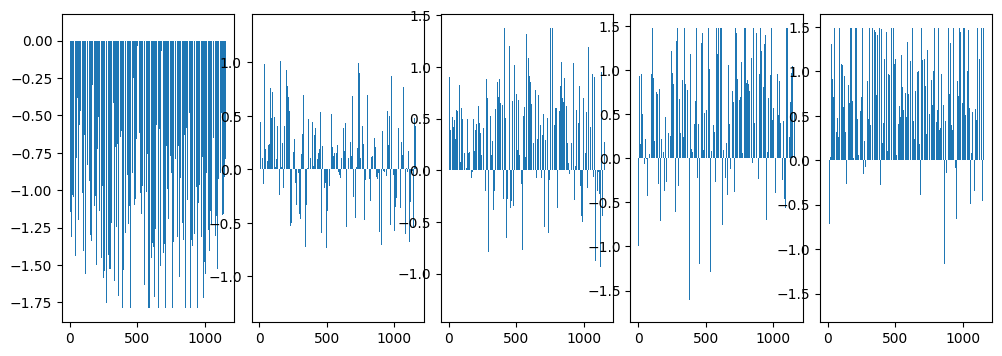

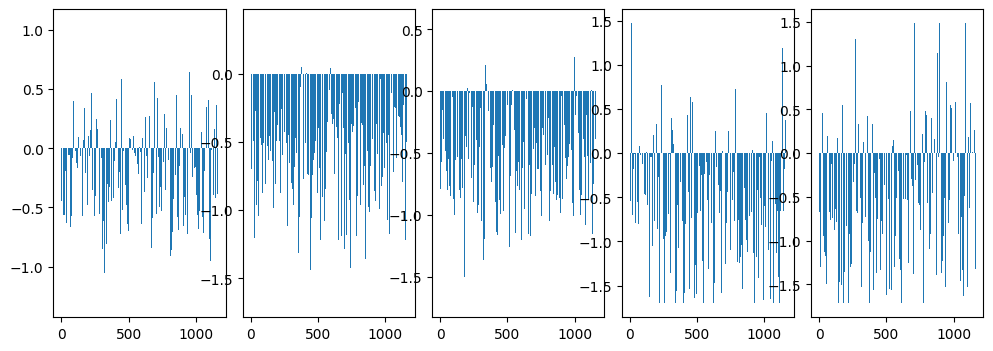

In [19]:

for unit in range(0, 2):

    fig = plt.figure(figsize=(12, 4))
    # and we add one plot per reference point
    gs = fig.add_gridspec(1, len(face_cell_resp_steps))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    for step in range(len(face_cell_resp_steps)):

        ax = plt.subplot(gs[0,step])

        unit_response = face_cell_resp_steps[step][unit].reshape(-1, 1)
        unit_response = unit_response.squeeze()
        x = np.arange(len(unit_response))  # Creates an array [0, 1, 2, ..., len(data)-1]

        # Create the bar plot
        ax.bar(x, unit_response)
    plt.show()

[0.         0.18091641 0.1544656  0.13785317 0.07742125]


Text(0, 0.5, 'correlation')

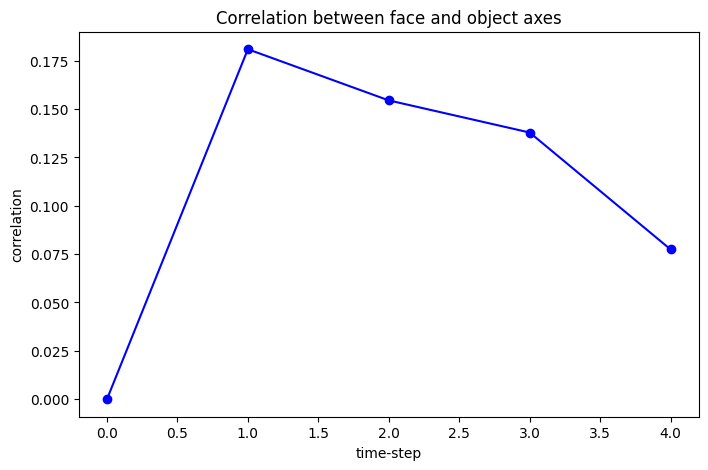

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_preferred_axis(r, F):
    """
    Compute the preferred axis of each cell using linear regression.

    Parameters:
    - r: 1D numpy array of firing rates (n,)
    - F: 2D numpy array of feature matrix (n x d)

    Returns:
    - P_lin: 1D numpy array of the preferred axis (d,)
    """
    # Compute mean firing rate
    mean_firing_rate = np.mean(r)

    # Center the firing rate vector by subtracting the mean firing rate
    r_centered = r - mean_firing_rate

    # Compute the inverse of (F^T F)
    FtF = np.dot(F.T, F)
    FtF_inv = np.linalg.inv(FtF)

    # Compute the preferred axis
    P_lin = np.dot(np.dot(r_centered, F), FtF_inv)

    return P_lin


p_lin_faces_all = np.zeros((*face_cell_resp_steps.shape[0:2], feats_transformed['fc6'].shape[1]))
p_lin_nonfaces_all = np.zeros((*face_cell_resp_steps.shape[0:2], feats_transformed['fc6'].shape[1]))
face_nonface_sim = np.zeros((face_cell_resp_steps.shape[0], face_cell_resp_steps.shape[1]))

for step in range(1,len(face_cell_resp_steps)):
    for unit in range(face_cell_resp_steps.shape[1]):

        unit_response = face_cell_resp_steps[step][unit].reshape(-1, 1)

        unit_response_to_faces = unit_response[labels==0].transpose()
        unit_response_to_nonfaces = unit_response[labels!=0].transpose()

        fc6_pca_faces = feats_transformed['fc6'][labels==0]
        fc6_pca_nonfaces = feats_transformed['fc6'][labels!=0]

        p_lin_nonfaces = compute_preferred_axis(unit_response_to_nonfaces, fc6_pca_nonfaces)
        p_lin_nonfaces_all[step, unit] = p_lin_nonfaces

        p_lin_faces = compute_preferred_axis(unit_response_to_faces, fc6_pca_faces)
        p_lin_faces_all[step, unit] = p_lin_faces

        sim = stats.pearsonr(p_lin_faces.squeeze(), p_lin_nonfaces.squeeze())[0]
        #print(stats.pearsonr(p_lin_faces.squeeze(), p_lin_nonfaces.squeeze()))
        #sim = cosine_similarity(p_lin_faces, p_lin_nonfaces)
        #print(cosine_similarity(p_lin_faces, p_lin_nonfaces))

        face_nonface_sim[step, unit] = sim
        

axes_sim = np.mean(face_nonface_sim, axis=1)
print(axes_sim)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(axes_sim)), axes_sim, marker='o', linestyle='-', color='b')  # Plot points and connect them
plt.title('Correlation between face and object axes')
plt.xlabel('time-step')
plt.ylabel('correlation')

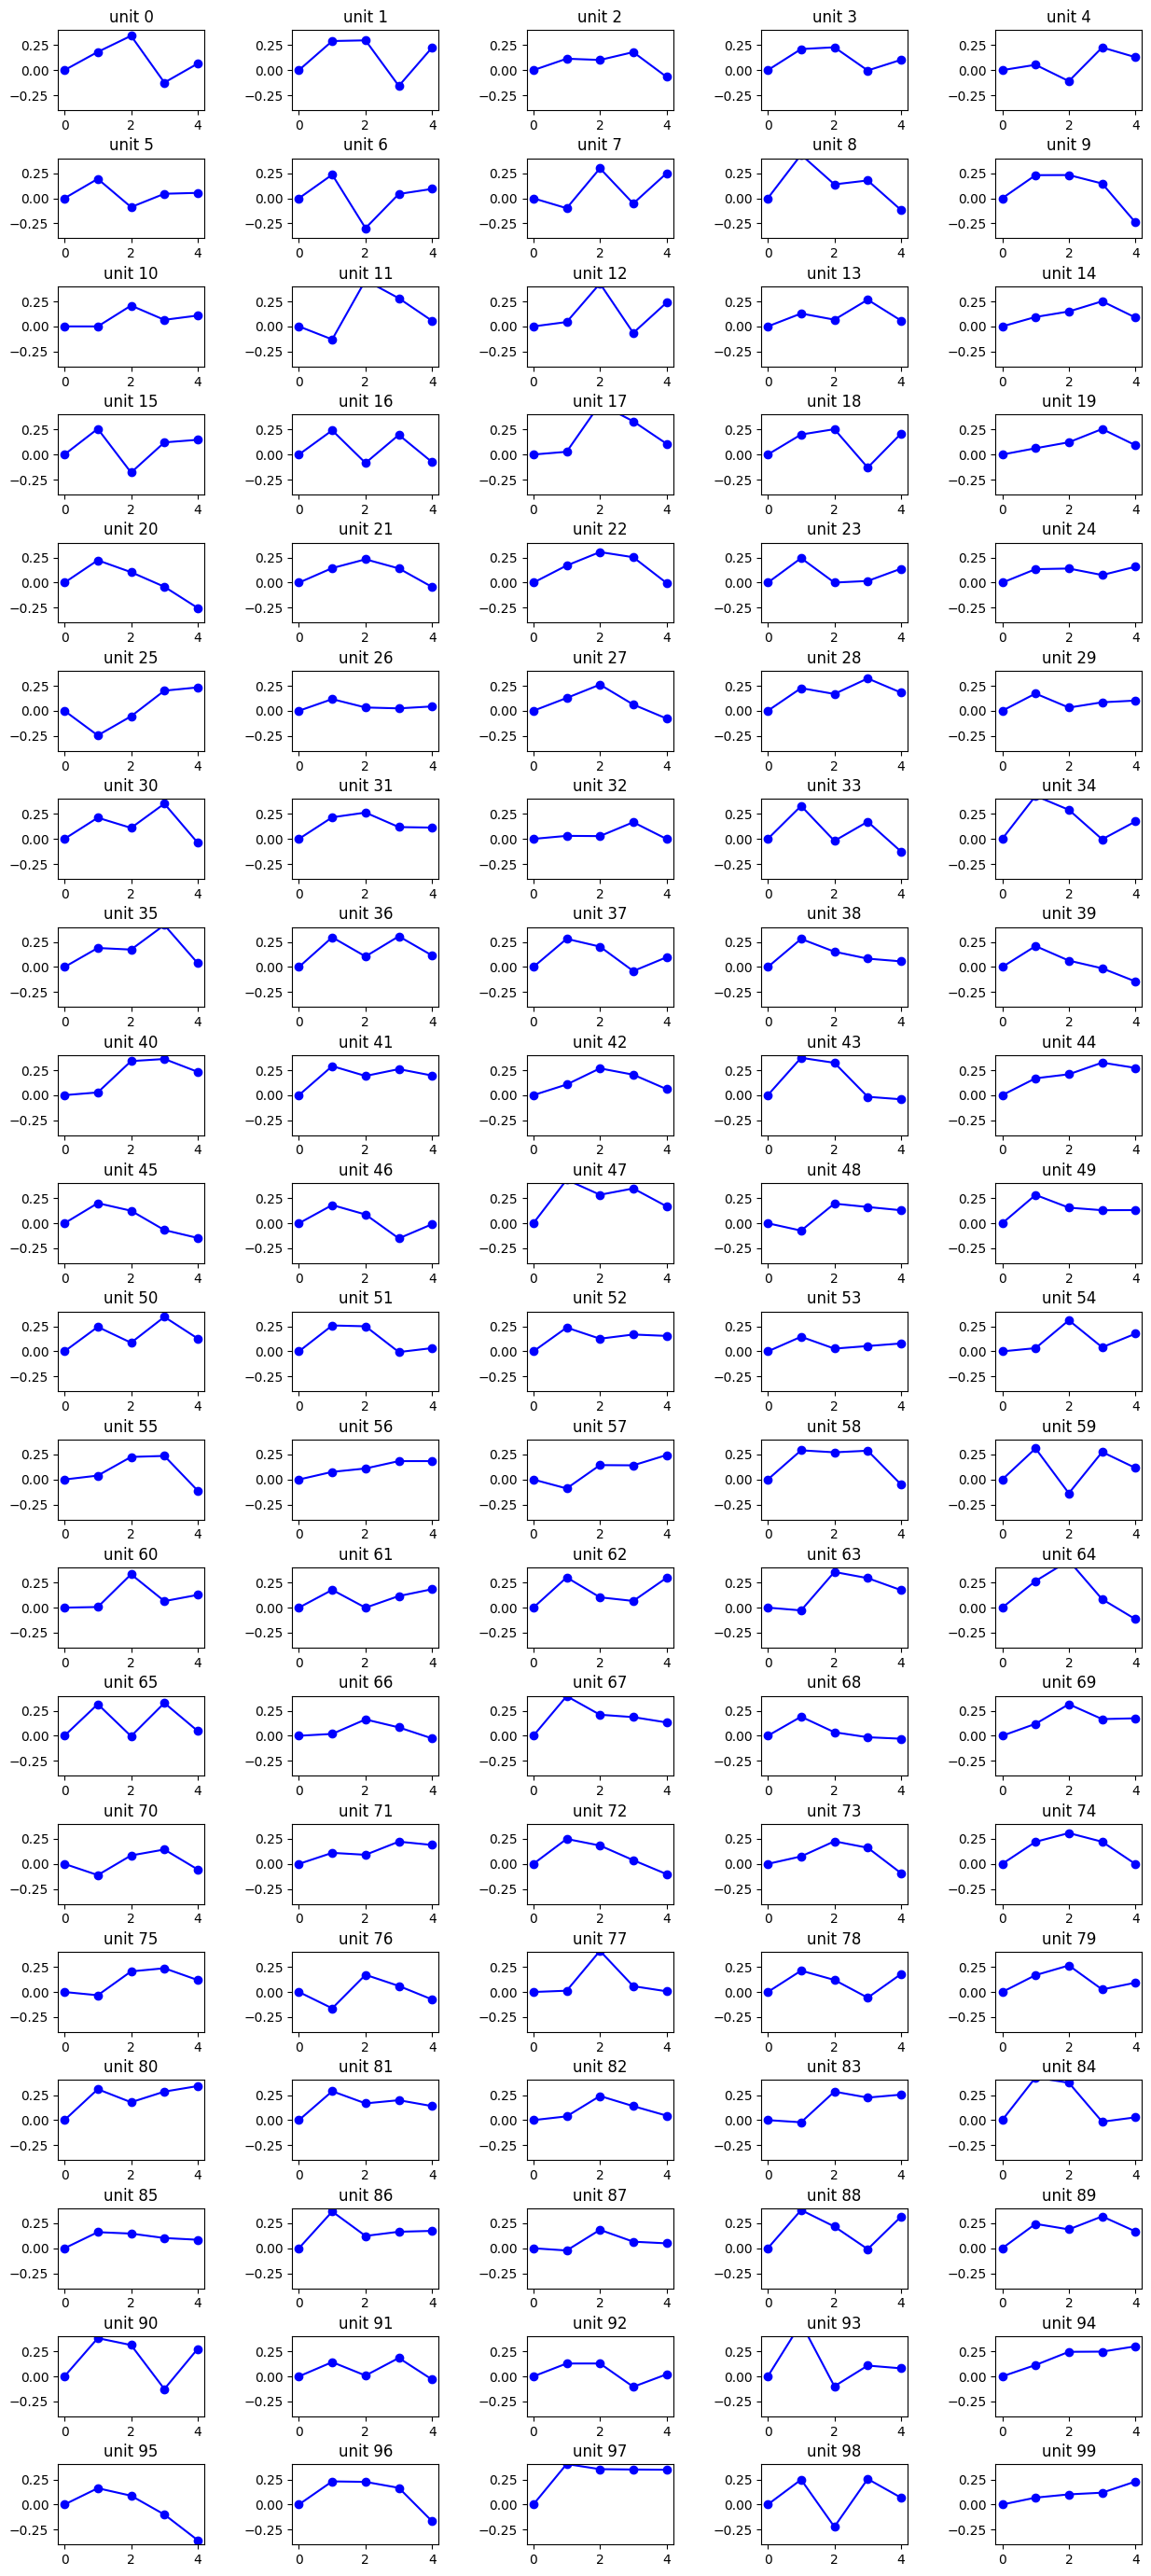

In [21]:


fig = plt.figure(figsize=(15, 35))
# and we add one plot per reference point
r, c = 20, 5
gs = fig.add_gridspec(r, c)
fig.subplots_adjust(wspace=0.6, hspace=0.6)

for u in range(r): #face_nonface_sim.shape[1]):
    for v in range(c): #face_nonface_sim.shape[1]):
        unit = u*c + v
        ax = plt.subplot(gs[u,v])
        ax.plot(np.arange(len(axes_sim)), face_nonface_sim[:,unit], marker='o', linestyle='-', color='b') 

        #ax.set_xlim([amin, amax])
        ax.set_ylim([-0.4, 0.4])
        ax.set_title(f'unit {unit}')
plt.show() # Plot points and connect them
